In [1]:
# !pip install opencv-python scikit-learn pandas numpy matplotlib tensorflow-addons
# !pip install tensorflow==2.12 keras==2.12
# !pip install transformers datasets torchvision

In [51]:
import os
import copy
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from transformers import DeiTForImageClassification, AutoImageProcessor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.autonotebook import tqdm

In [52]:
CONFIG = {
    'data_path': '/kaggle/input/lung-cancer-detection-lidc-idri-subset/LIDC_IDRI_PNG_CONV',
    'model_name': 'facebook/deit-base-distilled-patch16-224',
    'epochs': 20, # User-defined number of epochs
    'batch_size': 16,
    'lr': 2e-5,
    'weight_decay': 0.01,
    'patience': 5,
    'min_delta': 1e-4,
    'num_workers': 2,
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu')
}

print(f"Using device: {CONFIG['device']}")

Using device: cuda


In [53]:
def custom_preprocess(img):
    img_np = np.array(img.convert('L'))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_np = clahe.apply(img_np)
    img_np = cv2.resize(img_np, (224, 224), interpolation=cv2.INTER_CUBIC)
    img_np = cv2.GaussianBlur(img_np, (5,5), 0)
    _, img_np = cv2.threshold(img_np, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3,3), np.uint8)
    img_np = cv2.erode(img_np, kernel, iterations=1)
    img_np = cv2.dilate(img_np, kernel, iterations=1)
    
    return Image.fromarray(img_np)

train_transform = transforms.Compose([
    transforms.Lambda(custom_preprocess),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(), # Converts the single-channel image to a [1, H, W] tensor
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # Duplicate to 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation and Test transforms do not include augmentation
val_test_transform = transforms.Compose([
    transforms.Lambda(custom_preprocess),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dir = os.path.join(CONFIG['data_path'], "train")
valid_dir = os.path.join(CONFIG['data_path'], "valid")
test_dir = os.path.join(CONFIG['data_path'], "test")

print(f"Using device: {CONFIG['device']}")

Using device: cuda


In [54]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=valid_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'], pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'], pin_memory=True)

num_classes = len(train_dataset.classes)

In [55]:
def train_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs).logits
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        
    return total_loss / len(loader), correct / total

def validate(model, loader, loss_fn, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).logits
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return total_loss / len(loader), correct / total

In [56]:
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
model = DeiTForImageClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=num_classes,
    ignore_mismatched_sizes=True
).to(CONFIG['device'])

optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

# NEW: Define the ReduceLROnPlateau scheduler
# It will monitor the validation loss (`mode='min'`)
# If val_loss doesn't improve for `patience=2` epochs, it will reduce the LR by a factor of 0.1.
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=2, 
    verbose=True
)

best_val_acc = 0
best_model_state = None
patience_counter = 0 # For early stopping
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(CONFIG['epochs']):
    print(f"\n{'='*50}\nEpoch {epoch+1}/{CONFIG['epochs']}\n{'='*50}")
    
    # The train_epoch function no longer needs the scheduler passed to it
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, CONFIG['device'])
    val_loss, val_acc = validate(model, val_loader, loss_fn, CONFIG['device'])
    
    # NEW: The scheduler's step is now called with the validation loss
    scheduler.step(val_loss)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping logic remains the same
    if val_acc > best_val_acc + CONFIG['min_delta']:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        patience_counter = 0
        print("✅ New best model!")
    else:
        patience_counter += 1
        if patience_counter >= CONFIG['patience']:
            print("⏹️ Early stopping triggered.")
            break

# Save the best performing model
torch.save(best_model_state, "best_model_reduce_lr.pth")
print(f"\n🎯 Best validation accuracy: {best_val_acc:.4f}")


## 7. Final Evaluation on Test Set
# ==================================================================
# This section remains the same
print("\nLoading best model for final evaluation on the test set...")
model.load_state_dict(best_model_state)
test_loss, test_acc = validate(model, test_loader, loss_fn, CONFIG['device'])
print(f"\n{'='*50}\nFINAL TEST SET PERFORMANCE\n{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"{'='*50}")

# Clean up GPU memory
torch.cuda.empty_cache()

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/20


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.4637, Train Acc: 0.8171
Val Loss: 0.4446, Val Acc: 0.8515
✅ New best model!

Epoch 2/20


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.3258, Train Acc: 0.9267
Val Loss: 0.2991, Val Acc: 0.9333
✅ New best model!

Epoch 3/20


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.2829, Train Acc: 0.9463
Val Loss: 0.3058, Val Acc: 0.9182

Epoch 4/20


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.2801, Train Acc: 0.9463
Val Loss: 0.3229, Val Acc: 0.9152

Epoch 5/20


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.2771, Train Acc: 0.9478
Val Loss: 0.2991, Val Acc: 0.9212

Epoch 6/20


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.2608, Train Acc: 0.9531
Val Loss: 0.2850, Val Acc: 0.9182

Epoch 7/20


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Train Loss: 0.2502, Train Acc: 0.9562
Val Loss: 0.2850, Val Acc: 0.9121
⏹️ Early stopping triggered.

🎯 Best validation accuracy: 0.9333

Loading best model for final evaluation on the test set...


Validation:   0%|          | 0/26 [00:00<?, ?it/s]


FINAL TEST SET PERFORMANCE
Test Loss: 0.2786
Test Accuracy: 0.9564


In [57]:
print("\nLoading best model for final evaluation on the test set...")
model.load_state_dict(best_model_state)
test_loss, test_acc = validate(model, test_loader, loss_fn, CONFIG['device'])
print(f"\n{'='*50}\nFINAL TEST SET PERFORMANCE\n{'='*50}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"{'='*50}")

torch.cuda.empty_cache()


Loading best model for final evaluation on the test set...


Validation:   0%|          | 0/26 [00:00<?, ?it/s]


FINAL TEST SET PERFORMANCE
Test Loss: 0.2786
Test Accuracy: 0.9564


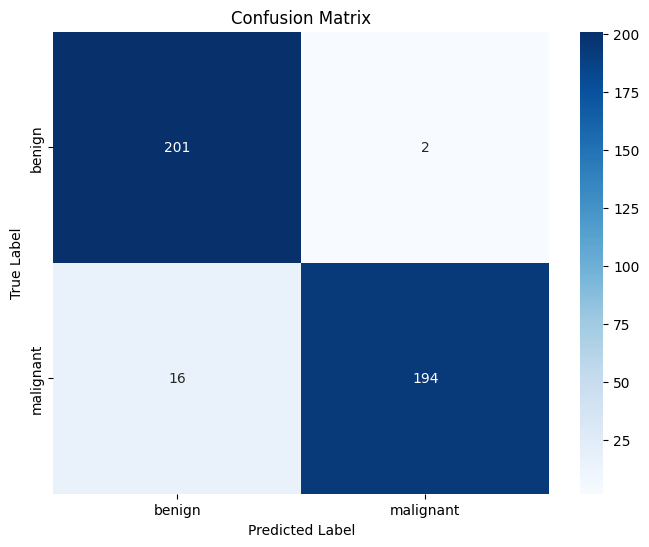

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Get predictions and true labels from test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(CONFIG['device'])
        labels = labels.to(CONFIG['device'])
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = test_dataset.classes  # Assumes test_dataset is an ImageFolder

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Analyzing model for all misclassified images...


Finding Errors:   0%|          | 0/26 [00:00<?, ?it/s]


Found 2 False Positive images (Benign as Malignant).
Found 16 False Negative images (Malignant as Benign).

--- Displaying False Positives ---


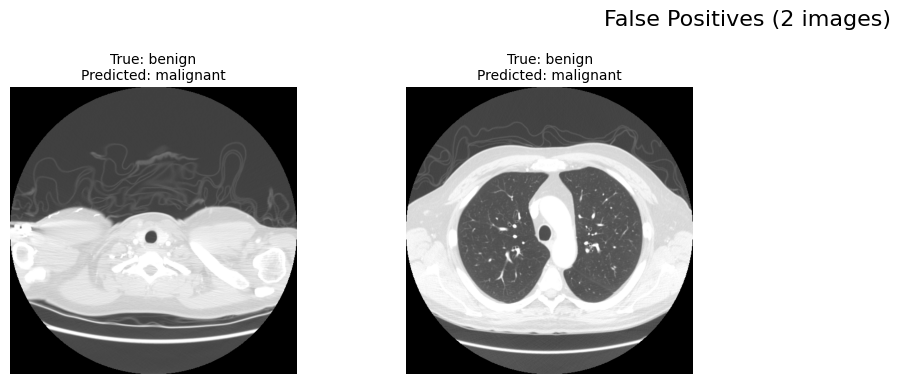


--- Displaying False Negatives ---


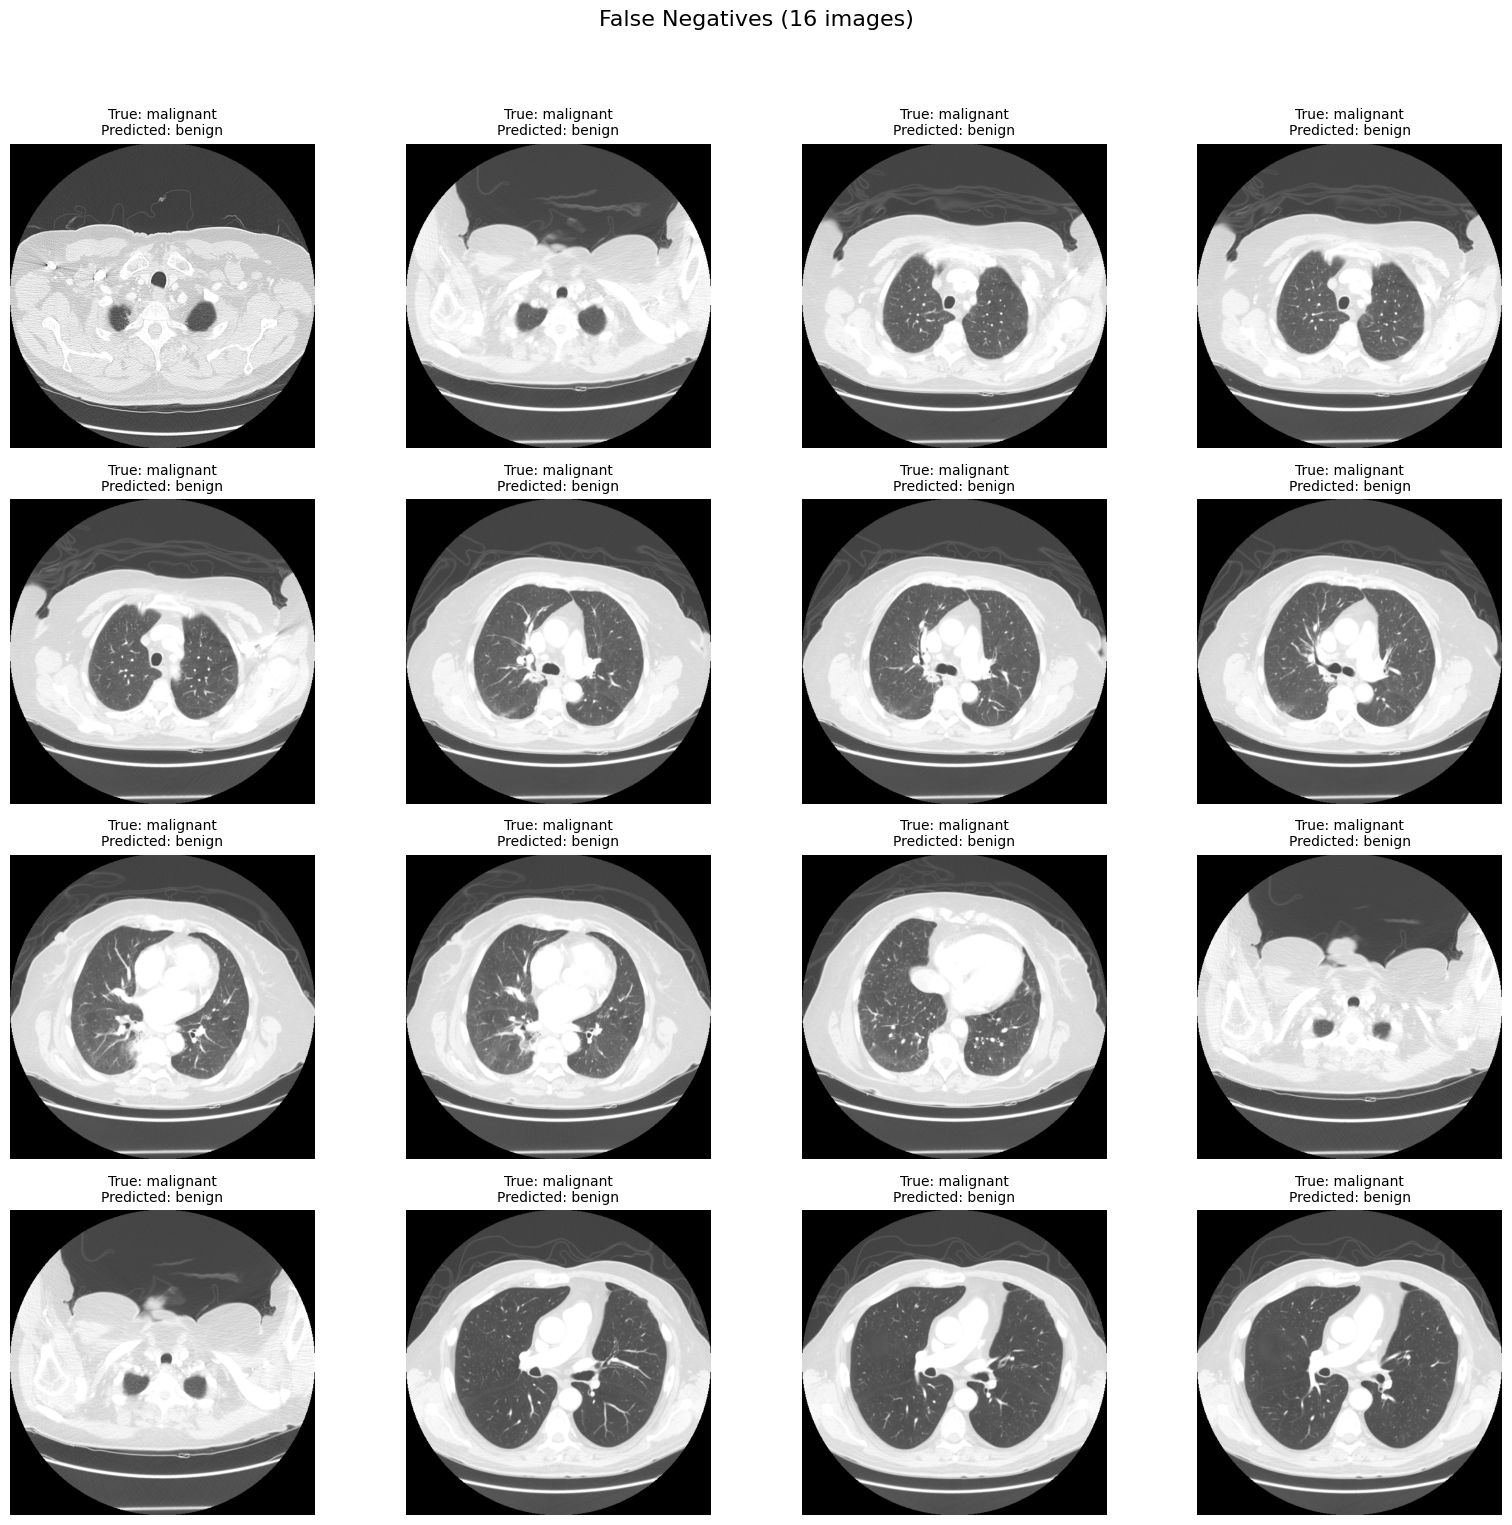

In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm.autonotebook import tqdm

# Ensure all required objects from the previous cells are available:
# model, test_loader, test_dataset, CONFIG

print("Analyzing model for all misclassified images...")

# 1. Load the best model state
# ==================================================================
model.load_state_dict(torch.load("best_model_reduce_lr.pth"))
model.to(CONFIG['device'])
model.eval()

# 2. Find all misclassified images
# ==================================================================
false_positives = []
false_negatives = []

# CORRECTED: Get file paths from the .samples attribute of ImageFolder
file_paths = [s[0] for s in test_dataset.samples]
class_names = test_dataset.classes

with torch.no_grad():
    image_index = 0
    for inputs, labels in tqdm(test_loader, desc="Finding Errors"):
        inputs = inputs.to(CONFIG['device'])
        labels = labels.to(CONFIG['device'])
        
        outputs = model(inputs).logits
        _, preds = torch.max(outputs, 1)
        
        for i in range(len(preds)):
            true_label_name = class_names[labels[i]]
            pred_label_name = class_names[preds[i]]
            
            if true_label_name != pred_label_name:
                sample_info = {
                    'file_path': file_paths[image_index],
                    'true_label': true_label_name,
                    'pred_label': pred_label_name
                }
                if true_label_name == 'benign' and pred_label_name == 'malignant':
                    false_positives.append(sample_info)
                elif true_label_name == 'malignant' and pred_label_name == 'benign':
                    false_negatives.append(sample_info)
            
            image_index += 1

print(f"\nFound {len(false_positives)} False Positive images (Benign as Malignant).")
print(f"Found {len(false_negatives)} False Negative images (Malignant as Benign).")


# 3. Visualize the misclassified images
# ==================================================================
def plot_errors(samples, error_type):
    if not samples:
        print(f"\n✅ No {error_type} found!")
        return
        
    print(f"\n--- Displaying {error_type} ---")
    num_images = len(samples)
    cols = 4
    rows = int(np.ceil(num_images / cols))
    
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    fig.suptitle(f'{error_type} ({num_images} images)', fontsize=16)
    
    for i, sample in enumerate(samples):
        img = Image.open(sample['file_path'])
        
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(img, cmap='gray')
        
        title_text = (
            f"True: {sample['true_label']}\n"
            f"Predicted: {sample['pred_label']}"
        )
        ax.set_title(title_text, fontsize=10)
        ax.axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot both types of errors
plot_errors(false_positives, "False Positives")
plot_errors(false_negatives, "False Negatives")

In [62]:
import torch
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
import numpy as np

# Ensure your model, test_loader, and CONFIG are loaded and defined

# Load the best model state
model.load_state_dict(torch.load("best_model_reduce_lr.pth"))
model.to(CONFIG['device'])
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Getting Predictions"):
        inputs = inputs.to(CONFIG['device'])
        
        outputs = model(inputs).logits
        
        # Get prediction probabilities for the ROC curve
        # We apply softmax to the logits to get probabilities
        probs = F.softmax(outputs, dim=1)
        
        # Get the predicted class (0 or 1)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# Convert to numpy arrays for easier use with sklearn
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

Getting Predictions:   0%|          | 0/26 [00:00<?, ?it/s]

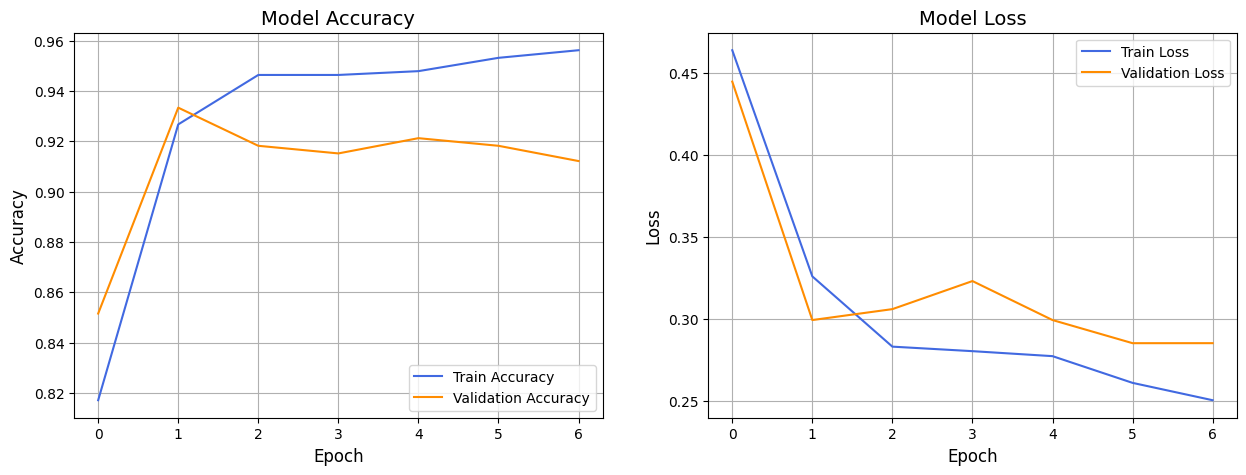

In [63]:
import matplotlib.pyplot as plt

# Ensure your 'history' dictionary from the training loop is available
# history = {'train_loss': [...], 'train_acc': [...], 'val_loss': [...], 'val_acc': [...]}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting accuracy
ax1.plot(history['train_acc'], label='Train Accuracy', color='royalblue')
ax1.plot(history['val_acc'], label='Validation Accuracy', color='darkorange')
ax1.set_title('Model Accuracy', fontsize=14)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend()
ax1.grid(True)

# Plotting loss
ax2.plot(history['train_loss'], label='Train Loss', color='royalblue')
ax2.plot(history['val_loss'], label='Validation Loss', color='darkorange')
ax2.set_title('Model Loss', fontsize=14)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.show()

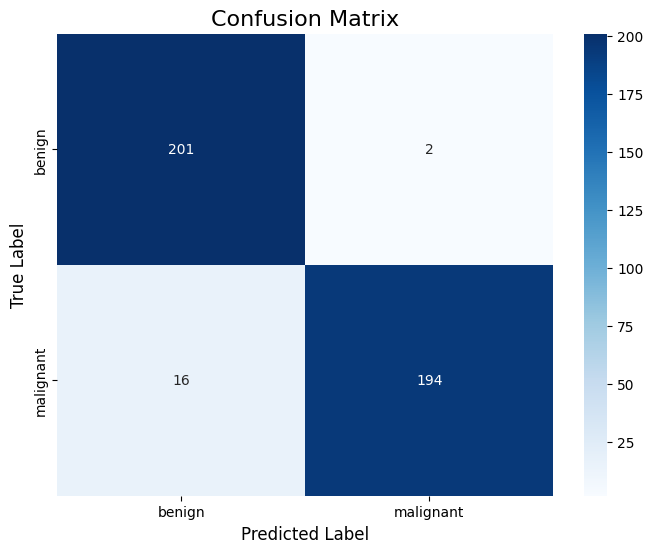

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Ensure class_names = ['benign', 'malignant'] is defined
class_names = test_dataset.classes

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [65]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

Classification Report:
              precision    recall  f1-score   support

      benign     0.9263    0.9901    0.9571       203
   malignant     0.9898    0.9238    0.9557       210

    accuracy                         0.9564       413
   macro avg     0.9580    0.9570    0.9564       413
weighted avg     0.9586    0.9564    0.9564       413



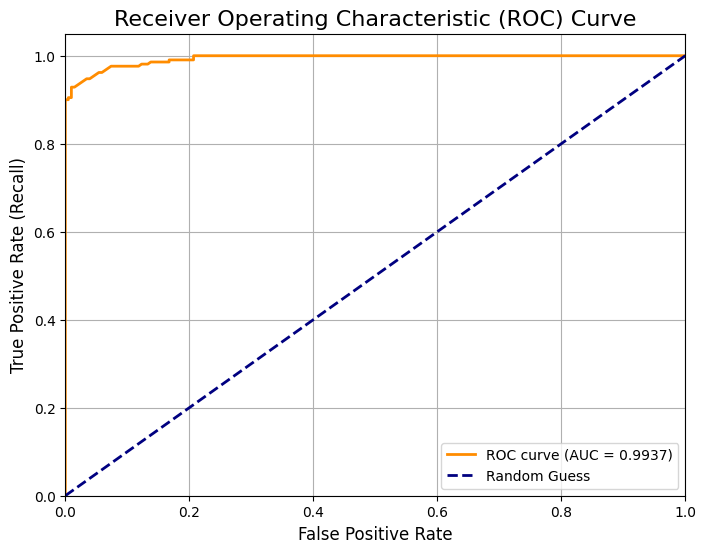

In [66]:
from sklearn.metrics import roc_curve, auc

# We need the probabilities for the 'malignant' class (which is class 1)
malignant_probs = all_probs[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, malignant_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()